In [1]:
import numpy as np 
import pandas as pd 

import os

# всё ли на месте?
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mcs-hw03-say-my-name/test.tsv
/kaggle/input/mcs-hw03-say-my-name/sample.csv
/kaggle/input/mcs-hw03-say-my-name/train.tsv


## HW03: SAY MY NAME

В этой задаче вам предстоит запрограммировать несколько элементов архитектуры seq2seq, чтобы повысить качество преобразования графем в фонемы (условное название в данном случае).

![img](https://pytorch.org/tutorials/_images/seq2seq.png)

Использовать посторонние данные и предобученные модели нельзя, **готовые архитектуры за пределами стандартной библиотеки Pytorch** использовать также запрещено. Нет, huggingface нельзя. Нет, fairseq тоже нельзя :) Инструменты для машинного перевода вроде Joey/OpenNMT -- разумеется, тоже нельзя.

## Задание

Реализуйте пропущенные фрагменты архитектуры sequence-to-sequence with attention, усложните её, где считаете нужным (помните о регуляризаторах, разных способах оптимизации, расписании изменения скорости обучения и более современных компонентах нейронных сетей!), и добейтесь результата, превосходящего по качеству сабмит `b a s e l i n e` на Kaggle на Private Leaderboard (он откроется в конце); если ваше решение между `b a s e l i n e` и `vanilla` на Private Leaderboard, тоже засчитаем.

Сделать это нужно в kaggle kernel -- в таком же ноутбуке, как этот, и через него же сделать отправку решения (сабмит). Инструкции на сайте emkn.

"Бонусы" в конце не оцениваются -- это способы убедиться, что модель действительно научилась чему-то релевантному задаче.

In [2]:
%matplotlib inline

import torch
from torch import nn

import matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
torch.__version__

'2.0.0+cpu'

## Готовим данные

In [4]:
data_dir = "/kaggle/input/mcs-hw03-say-my-name/"
train_df = pd.read_csv(data_dir + "train.tsv", sep="\t")
test_df = pd.read_csv(data_dir + "test.tsv", sep="\t")
train_df

,id,src,tgt
0,0,SPORTSWRITER,S P AO1 R T S R AY2 T ER0
1,1,SKINS,S K IH1 N Z
2,2,ACHEY,AE1 CH IY0
3,3,SPINNER,S P IH1 N ER0
4,4,REALLOCATION,R IY0 AE2 L AH0 K EY1 SH AH0 N
...,...,...,...
74671,74671,SALINE,S AH0 L IY1 N
74672,74672,CALCUTTA,K AE2 L K AH1 T AH0
74673,74673,NERO,N IH1 R OW0
74674,74674,DENIALS,D IH0 N AY1 AH0 L Z


In [5]:
test_df.head()

,id,src
0,0,NICOR
1,1,LYONSS
2,2,HOLDERBY
3,3,KASTLER
4,4,CUNDIFF


### Конвертация графем

Будем работать на уровне букв, точнее, символов. Тут не только алфавит, поэтому придётся пробежаться по всем.

In [6]:
src_chars = sorted(set([ch for w in train_df["src"].dropna() for ch in w]))
print(src_chars, len(src_chars))

gr2id = {ch: i for i, ch in enumerate(src_chars)}
id2gr = {i: ch for i, ch in enumerate(src_chars)}

def grs2id(graphemes: str):
    return np.array([gr2id[c] for c in graphemes])

print(grs2id("ABCDE_Z"))


['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_'] 28
[ 1  2  3  4  5 27 26]


### Конвертация фонем

Нам понадобятся символы начала и конца строк -- для декодировщика. При авторегрессивном декодировании начинаем всегда с `^` (иногда обозначают `BOS` -- beginning of the string) как входа и останавливаемся, когда сгенерируем `$`. Им же и будем "добивать" строчки (padding), чтобы у них была равная длина.

In [7]:
phonemes = [phoneme
                   for item in train_df["tgt"] if type(item) == str
                   for phoneme in item.strip().split(" ") ] + ["^", "$"]

ph2id = {ph: i for i, ph in enumerate(sorted(set(phonemes)))}
id2ph = {i: ph for i, ph in enumerate(sorted(set(phonemes)))}

def phs2id(phonemes: str):
    return np.array([ph2id[c] for c in phonemes])


### Dataset/Dataloader

Уже привычные нам вещи. В базовом коде для простоты будет `batch_size` = 1. 

Но если хотите -- можете сделать батчинг для более эффективного обучения. Точно пригодится знание, как работает `torch.nn.functional.pad` :)

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SequencesDataset(Dataset):

    def __init__(self, df, transform=None):

        # из теста нельзя выбрасывать строчки
        self.colset = set(df.columns)
        self.df = df.dropna() if "tgt" in self.colset else df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        src = self.df.iloc[idx]["src"].strip()
        tgt = None

        # дополняем слева и справа символами начала
        # и конца строки соответственно
        if "tgt" in self.colset:
            tgt = ["^"] + self.df.iloc[idx]["tgt"].strip().split(" ") + ["$"]
            tgt = torch.tensor(phs2id(tgt))
            return torch.tensor(grs2id(src)), tgt
        
        return torch.tensor(grs2id(src))

In [9]:
test_dataloader = DataLoader(SequencesDataset(test_df), batch_size=1,
                             shuffle=False, num_workers=0)

train_dataloader = DataLoader(SequencesDataset(train_df), batch_size=1,
                              shuffle=True, num_workers=0)

Замеряем максимальные длины последовательностей.

In [10]:
max_len_input, max_len_output = 0, 0

for inp, outp in train_dataloader:
    max_len_input = max(inp.size(-1), max_len_input)
    max_len_output = max(outp.size(-1), max_len_output)

In [11]:
max_len_input, max_len_output

(22, 22)

## Модель: кодировщик-декодеровщик на основе RNN с вниманием

In [12]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted


### Encoder (кодировщик)

In [13]:
class Encoder(nn.Module):

    def __init__(self,
                 max_len: int,      # максимальная длина последовательности
                 vocab_size: int,   # размер словаря: какие бывают символы на входе
                 emb_size: int,     # размер эмбеддинга
                 hidden_size: int   # ширина скрытого слоя (внутр. состояния) RNN
                ) -> None:
        super().__init__()

        # сопоставляем индексу обучаемый вектор заданного размера
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=emb_size,
                                      padding_idx=max_len)

        # todo: может, заменить RNN на что-то поинтереснее? или слоёв добавить?
        self.rnn_in = nn.GRU(input_size=emb_size,
                             hidden_size=hidden_size,
                             batch_first=True)
        self.self_attention = SelfAttention(emb_size)
        
    def forward(self, input):
        # строим эмбеддинги по последовательности графем
        embeddings = self.embedding(input)
        weighted = self.self_attention(embeddings)
        

        # все скрытые состояния и последнее скрытое состояние
        all_states_in, final_state_vector = self.rnn_in(input=embeddings)
        return all_states_in, final_state_vector.squeeze(1)

Проверяем работоспособность (хотя бы всё ли в порядке с размерностями тензоров).

In [14]:
encoder = Encoder(max_len_input, vocab_size=len(gr2id),
                  emb_size=4, hidden_size=4)

batch_in, batch_out = next(iter(train_dataloader))

states, vector = encoder(batch_in)


### TODO: Реализуйте механизм внимания (Attention)

Можете выбрать любой (лишь бы работал), например, из [статьи Bahdanau'2014](https://arxiv.org/abs/1409.0473).

![img](https://i.imgur.com/1152PYf.png)

Ещё раз: можно и иначе!

In [15]:
from torch.nn import functional as F

class MyOwnAttention(nn.Module):

    def __init__(self, 
                 hidden_size,     # размер скрытого слоя самого внимания
                 query_emb_size,  # размер эмбеддинга из декодировщика
                 key_emb_size):   # размер каждого скрытого слоя кодировщика
        super(MyOwnAttention, self).__init__()
        self.linear_encode = nn.Linear(key_emb_size, hidden_size)
        self.linear_decode = nn.Linear(query_emb_size, hidden_size)
        self.linear_sum = nn.Linear(hidden_size, 1)
    
    

    def forward(self, query_embedding, key_embs):
        # todo: преобразовываем к одному размеру  `hidden_size` линейными слоями 
        # todo: и состояния кодировщика, и состояние декодировщика, и складываем все эмбеддинги

        transformed_embs = self.linear_encode(key_embs) + self.linear_decode(query_embedding)
        # todo: считаем по ним "скоры", применяя нелинейность и линейный слой
        scores = self.linear_sum(F.tanh(transformed_embs))   # последовательность скаляров -- "скоров"
        scores = scores.squeeze(2).unsqueeze(1)
        # превращаем софтмаксом сырые "скоры" в "распределение", т.е. веса внимания
        weights = F.softmax(scores, dim=-1)

        # взвешиваем вниманием эмбеддинги кодировщика
        context = torch.bmm(weights, key_embs)
        return context.view(-1, context.shape[-1]), weights

### Decoder

Авторегрессивный, реализация попротивнее, чем кодировщик.

In [16]:
class DecoderWithAttention(nn.Module):

    def __init__(self,
               max_inp_len: int = 10,                 # максимальная длина входной последовательности
               max_outp_len: int=10,                  # максимальная длина выходной последовательности
               vocab_size: int=28,                    # размер словаря фонем
               emb_size: int=32,                      # размер эмбеддинга
               hidden_size: int=64,                   # размер скрытого слоя декодировщика
               encoder_hidden_size=64,                # размер скрытого слоя кодировщика
               attention_hidden_size=32,              # размер скрытого слоя внимания 
               start_code_token_id:int=phs2id("^"),   # номер токена начала строки -- из словаря
               end_code_token_id:int=phs2id("$")      # номер токена конца строки -- из словаря
                ) -> None:
        
        super().__init__()
        assert encoder_hidden_size == hidden_size

        # предельные длины последовательностей
        self.max_output_length, self.max_input_length = max_outp_len, max_inp_len

        # todo: представления токена на входе
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=emb_size,
                                      padding_idx=max_inp_len)

        # внимание, которое смотрит на этот эмбеддинг и на скрытые
        # состояния кодировщика, которые должны быть переданы
        self.attention = MyOwnAttention(hidden_size=attention_hidden_size,
                                        query_emb_size=emb_size,
                                        key_emb_size=encoder_hidden_size)
        
        # рекуррентная ячейка (может, есть что-то получше?)
        self.decoder_cell = nn.GRUCell(input_size=encoder_hidden_size + emb_size,
                                       hidden_size=hidden_size)
        
        # todo: линейный слой, предсказывающий очередной выход
        self.linear_cell = nn.Linear(hidden_size, vocab_size)

        self.start_code_token_id = start_code_token_id
        self.end_code_token_id = end_code_token_id


    def forward(self, all_states_in, final_state_vector):

        # каждая строка начинается с "^"
        token = torch.tensor(self.start_code_token_id, requires_grad=False)
        
        # стартуем с последнего вектора состояний кодировщика
        rnn_state = final_state_vector
        
        predictions_raw, predictions_hard = [], []

        for step_idx in range(self.max_output_length):
            #  эмбеддим входной токен
            emb = self.embedding(token)
            
            #  todo: применяем механизм внимания, используя скрытые состояния кодировщика

            weighted_context, attention_weights = self.attention(emb, all_states_in)
            
            # делаем шаг рекуррентной сетью
            rnn_state = self.decoder_cell(torch.cat([weighted_context, emb.view(1, -1)], 1), rnn_state)
            
            
            # todo: получаем логиты очередного токена
            token_soft = self.linear_cell(rnn_state)
            
            # todo: получаем номер очередного предсказанного токена в словаре
            token = token_soft.argmax()
            
            # сохраняем обе версии предсказаний: для лосса и для следующего шага
            predictions_raw.append(token_soft)
            predictions_hard.append(token.item())

            # если символ конца строки, останавливаемся
            if token.item() == self.end_code_token_id:
                break

        return torch.concat(predictions_raw, dim=-2), predictions_hard

Проверяем

In [17]:
batch_in, batch_out = next(iter(train_dataloader))


In [18]:
encoder = Encoder(max_len_input, vocab_size=len(gr2id), emb_size=4, hidden_size=4)
# batch_in, batch_out = next(iter(train_dataloader))

states, vector = encoder(batch_in)

decoder = DecoderWithAttention(max_inp_len=max_len_input,
                               max_outp_len=max_len_output,
                               vocab_size=len(ph2id), emb_size=4,
                               hidden_size=4, encoder_hidden_size=4,
                               attention_hidden_size=4)

predictions_lsm, predictions_hard = decoder(all_states_in=states, final_state_vector=vector)

predictions_lsm.size(), (predictions_hard)

(torch.Size([22, 71]),
 [57,
  37,
  47,
  28,
  28,
  47,
  28,
  28,
  47,
  28,
  28,
  47,
  28,
  28,
  47,
  28,
  28,
  47,
  28,
  28,
  47,
  28])

One `torch.nn.Module` to bring them all and in the darkness bind them.

In [19]:
class EncoderDecoderWithAttention(nn.Module):

    def __init__(self, encoder, decoder) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_sequence):
        states, vector = self.encoder(input_sequence)
        predictions_lsm, predictions_hard = decoder(all_states_in=states, final_state_vector=vector)
        return predictions_lsm, predictions_hard

Проверяем.

In [20]:
encdec = EncoderDecoderWithAttention(encoder, decoder)

print(encdec(batch_in)[1])

encdec

[57, 37, 47, 28, 28, 47, 28, 28, 47, 28, 28, 47, 28, 28, 47, 28, 28, 47, 28, 28, 47, 28]


EncoderDecoderWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(28, 4, padding_idx=22)
    (rnn_in): GRU(4, 4, batch_first=True)
    (self_attention): SelfAttention(
      (query): Linear(in_features=4, out_features=4, bias=True)
      (key): Linear(in_features=4, out_features=4, bias=True)
      (value): Linear(in_features=4, out_features=4, bias=True)
      (softmax): Softmax(dim=2)
    )
  )
  (decoder): DecoderWithAttention(
    (embedding): Embedding(71, 4, padding_idx=22)
    (attention): MyOwnAttention(
      (linear_encode): Linear(in_features=4, out_features=4, bias=True)
      (linear_decode): Linear(in_features=4, out_features=4, bias=True)
      (linear_sum): Linear(in_features=4, out_features=1, bias=True)
    )
    (decoder_cell): GRUCell(8, 4)
    (linear_cell): Linear(in_features=4, out_features=71, bias=True)
  )
)

## Собираем всё вместе

Тут, думаю, комментарии не нужны, уже всё это делали.

In [21]:
from torch import optim
from torch.nn import CrossEntropyLoss


encoder = Encoder(max_len_input, vocab_size=len(gr2id),
                  emb_size=512, hidden_size=256)

decoder = DecoderWithAttention(max_inp_len=max_len_input,
                               max_outp_len=max_len_output,
                               vocab_size=len(ph2id), emb_size=512,
                               hidden_size=256, encoder_hidden_size=256,
                               attention_hidden_size=256)

encdec = EncoderDecoderWithAttention(encoder, decoder)

test_dataloader = DataLoader(SequencesDataset(test_df), batch_size=1,
                             shuffle=False, num_workers=0)
train_dataloader = DataLoader(SequencesDataset(train_df), batch_size=1,
                              shuffle=True, num_workers=0)

In [22]:
optimizer = optim.Adam(encdec.parameters(), lr = 0.00008)
criterion = CrossEntropyLoss()

## Обучение

Может, стоит несколько эпох поучить? Попробовать разные оптимизаторы? Подумать над регуляризацией и гиперпараметрами? Иногда отслеживать, как ведёт себя ЦЕЛЕВАЯ метрика, а не только невязка?

In [23]:
!pip install python-Levenshtein


In [24]:
import Levenshtein


In [25]:
encdec.train()

reporting = 500
loss_last = []
num_epoch = 7
for _ in range(num_epoch):
    for idx, (input_seq, output_seq) in enumerate(train_dataloader):

        encdec.zero_grad()
        output, predictions_hard = encdec(input_seq)

        # задаём равные длины
        output_true = F.pad(output_seq.squeeze(),
                            pad=(0, output.size(0) - output_seq.size(-1)),
                            value=ph2id["$"])

        loss = criterion(output, output_true)
        loss_last.append(loss.detach())

        loss.backward()
        optimizer.step()

        if idx > 0 and idx % reporting == 0:
            print(f"Loss: {np.mean(loss_last):2.4f}+-{np.std(loss_last):2.4f}")
            loss_last = []

        if idx % 3000 == 0:

            orig_gr = "".join([id2gr[int(i)] for i in input_seq[-1].detach()])
            orig_ph = "".join([id2ph[int(i)] for i in output_seq[-1].detach()][1:-1])
            preds = "".join([id2ph[int(i)] for i in predictions_hard][1:-1])

            print(f"Sample #{idx}: {orig_gr} >> {orig_ph}")
            print('levenshtein score = ', Levenshtein.distance(orig_ph, preds))
            print(f"Prediction: ", preds)


Sample #0: PASQUALE >> PAA0SKWAA1LEY0
levenshtein score =  38
Prediction:  AA0AH2AH2AW1AE1JHER0AE1IH0PPUW2IY1RAH2WFAE2AY0N
Loss: 3.2031+-0.4568
Loss: 2.6241+-0.3841
Loss: 2.3428+-0.4391
Loss: 2.2103+-0.4707
Loss: 2.1194+-0.4815
Loss: 2.0828+-0.5034
Sample #3000: HIVELY >> HHAY1VLIY0
levenshtein score =  6
Prediction:  HHIH1LLL
Loss: 1.9623+-0.4868
Loss: 1.9335+-0.5428
Loss: 1.8466+-0.5630
Loss: 1.7965+-0.5727
Loss: 1.7525+-0.5968
Loss: 1.7151+-0.5881
Sample #6000: BUSKEY >> BAH1SKIY2
levenshtein score =  4
Prediction:  BIH1SK
Loss: 1.6536+-0.5868
Loss: 1.6347+-0.6277
Loss: 1.5654+-0.6420
Loss: 1.5897+-0.6182
Loss: 1.5588+-0.6467
Loss: 1.5201+-0.6437
Sample #9000: HARGAN >> HHAA1RGAH0N
levenshtein score =  1
Prediction:  HHAE1RGAH0N
Loss: 1.4606+-0.6786
Loss: 1.4446+-0.6570
Loss: 1.4138+-0.6550
Loss: 1.3854+-0.6705
Loss: 1.3915+-0.6568
Loss: 1.4169+-0.6918
Sample #12000: MORASH >> MAO1RAH0SH
levenshtein score =  3
Prediction:  MAA1RAH0
Loss: 1.3165+-0.6895
Loss: 1.2798+-0.6653
Loss: 1.3

In [26]:
encdec.eval()

data = []

for idx, (input_seq, ) in enumerate(test_dataloader):
    with torch.no_grad():
        _, predictions_hard = encdec(input_seq.unsqueeze(0))
        ph_predictions = [id2ph[int(i)] for i in predictions_hard][1:-1]
        data.append({"id": idx, "tgt": " ".join(ph_predictions)})

pd.DataFrame(data).to_csv("/kaggle/working/my_submission.csv", index=False)

## Bonus: карта внимания

На конкретном примере посмотрим, куда при декодировании очередного символа смотрит механизм внимания.

In [27]:
encdec.eval()

test_sequence = "blues".upper()
test_input = torch.tensor(grs2id(test_sequence)).unsqueeze(0)

with torch.no_grad():

    # по сути делаем то же, что и раньше
    enc_states, enc_last_state = encdec.encoder(test_input)
    dec = encdec.decoder

    # начальный токен
    token = torch.tensor([ph2id["^"]], requires_grad=False)

    # последнее состояние кодировщика
    rnn_state = enc_last_state

    # то, что нам понадобится для анализа
    predictions_hard, attention_scores = [], []

    for step_idx in range(dec.max_output_length):

        emb = dec.embedding(token)
        
        # применяем внимание
        ctx, attention_weights = dec.attention(emb, enc_states)
        attention_scores.append(attention_weights.squeeze())

        # делаем шаг рекуррентной сети
        rnn_state = dec.decoder_cell(torch.cat([ctx, emb], 1), rnn_state)

        # предсказываем токен
        token_soft = dec.linear_cell(rnn_state)
        token = torch.argmax(token_soft, dim=-1)
        predictions_hard.append(token.item())

        if token.item() == ph2id["$"]:
            break

Соберём всё, что хотим нарисовать

In [28]:
att_matrix = torch.vstack(attention_scores).numpy()
human_readable_predictions = [id2ph[i] for i in predictions_hard]
att_matrix.shape, human_readable_predictions

((6, 5), ['^', 'B', 'L', 'UW1', 'Z', '$'])

Собственно карта

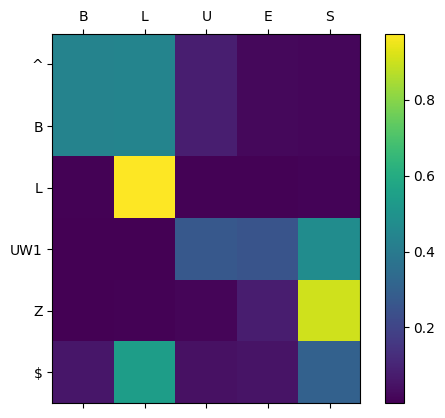

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(att_matrix, interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(att_matrix.shape[1])
yaxis = np.arange(att_matrix.shape[0])
ax.set_xticks(xaxis)
ax.set_yticks(yaxis)
ax.set_xticklabels(list(test_sequence))
ax.set_yticklabels(human_readable_predictions)

pass

## Bonus: эмбеддинги звуков

Убедимся, что модель поняла, какие звуки похожи друг на друга. С натяжкой можно сказать, что это косвенная проверка, удалось ли чему-нибудь обучиться.

По крайней мере, нарисуем так, что близкие друг к другу звуки должны быть действительно близко и при понижении размерности с помощью UMAP.

In [30]:
! python -m pip install -q umap-learn[plot]

In [31]:
encdec.eval()

with torch.no_grad():

    phonemes, embeddings = [], []

    for ph, id in ph2id.items():
        phonemes.append(ph)
        embeddings.append(encdec.decoder.embedding(torch.tensor(id)).numpy())

vectors = np.vstack(embeddings)

Стоит настроить гиперпараметры

In [32]:
import umap

reducer = umap.UMAP(n_neighbors=15)
reduced = reducer.fit_transform(vectors)

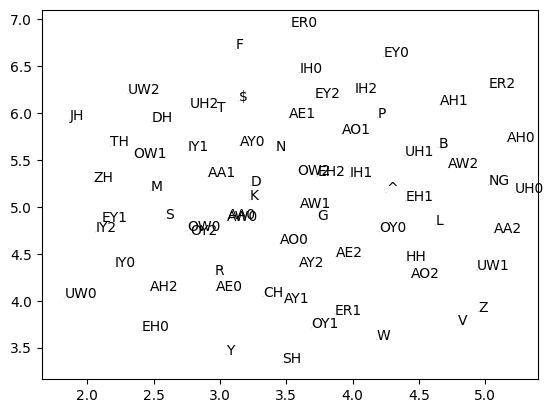

In [33]:
fig, ax = plt.subplots()
ax.scatter(reduced[:, 0], reduced[:, 1], alpha=0.3, edgecolors='none', s=1.0)

for i, txt in enumerate(phonemes):
    ax.annotate(txt, (reduced[i, 0], reduced[i, 1]))